# Example EAST

**WARNING** : This notebook is still experimental, and will be updated in future version. There are some known issues in data processing, and the model seems to overfit on `COCO Text`, these two issues will be solved in future updates.

In [1]:
import cv2
import importlib
import numpy as np
import pandas as pd
import tensorflow as tf

from utils import *
from models import get_pretrained
from datasets import get_dataset, prepare_dataset, test_dataset_time
from models.detection import EAST

model_name = 'east_vgg_text'

In [2]:
model = EAST(
    labels = 'text', input_size = (512, 512, 3), architecture = 'VGGUNet', nom = model_name
)

print(model)

Initializing model with kwargs : {'model': {'architecture_name': 'VGGUNet', 'input_shape': (512, 512, 3), 'output_dim': [1, 5], 'final_activation': ['sigmoid', 'sigmoid', 'softmax'], 'final_name': ['score_map', 'geo_map', 'class']}}
Initializing submodel : `model` !
Submodel model saved in pretrained_models\east_vgg_text\saving\model.json !
Model east_vgg_text initialized successfully !

========== east_vgg_text ==========
Sub model model
- Inputs 	: (None, 512, 512, 3)
- Outputs 	: [(None, 512, 512, 1), (None, 512, 512, 5)]
- Number of layers 	: 70
- Number of parameters 	: 20.607 Millions
- Model not compiled

Already trained on 0 epochs (0 steps)

- Image size : (512, 512, 3)
- Normalization style : None
- Labels (n = 1) : ['text']



## Model initialization + dataset loading

In [2]:
model = get_pretrained(model_name)

lr = {'name' : 'DivideByStep', 'maxval' : 1e-3, 'minval' : 1e-4}

model.compile(optimizer = 'adam', optimizer_config = {'lr' : lr}, loss_config = {'from_logits' : True})

Model restoration...
Initializing submodel : `model` !
Successfully restored model from pretrained_models/east_vgg_text/saving/model.json !
Model east_vgg_text initialized successfully !
Optimizer 'model_optimizer' initilized successfully !
Submodel model compiled !
  Loss : {'reduction': 'none', 'name': 'EASTLoss', 'from_logits': True, 'dice_smoothing': 0.01, 'geo_smoothing': 1.0, 'score_factor': 1.0, 'rbox_factor': 1.0, 'theta_factor': 10.0}
  Optimizer : {'name': 'Adam', 'learning_rate': {'class_name': 'DivideByStep', 'config': {'factor': <tf.Tensor: shape=(), dtype=float32, numpy=1.0>, 'minval': <tf.Tensor: shape=(), dtype=float32, numpy=1e-04>, 'maxval': <tf.Tensor: shape=(), dtype=float32, numpy=0.001>}}, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}
  Metrics : []


In [3]:
dataset = get_dataset('coco_text')

if isinstance(dataset, dict):
    train, valid = dataset['train'], dataset['valid']
else:
    train, valid = dataset, dataset

print('Dataset length :\n  Train length : {}\n  Valid length : {}'.format(
    len(train), len(valid)
))

Loading dataset coco_text...
Dataset length :
  Train length : 13880
  Valid length : 3261


## Training

In [ ]:
epochs     = 5
batch_size = 16

shuffle_size = batch_size * 16

model.train(
    train, validation_data = valid, epochs = epochs, batch_size = batch_size,
    
    is_rectangular = False
)

In [ ]:
model.plot_history()

## Test prediction with dataset

In [ ]:
config = model.get_dataset_config(batch_size = 1)

ds = prepare_dataset(train, ** config, is_rectangular = False)

for inp, out in ds.take(3):
    pred = model(inp)
    
    plot_multiple(
        score_map = out[0][0], pred_score = pred[0][0],
        d0_map = out[1][0, ..., 0], d0_pred = pred[1][0, ..., 0] * 512,
        plot_type = 'imshow'
    )

## Dataset

In [ ]:
from datasets import *
from loggers import set_level

set_level('debug', 'datasets')

config = model.get_dataset_config(batch_size = 16)

dataset = get_dataset('coco_text', modes = 'valid')
ds      = prepare_dataset(dataset, ** config, is_rectangular = False)

set_level('info', 'datasets')

test_dataset_time(ds)

In [ ]:
config = model.get_dataset_config(batch_size = 16)

ds = prepare_dataset(train, ** config, is_rectangular = False)

for inp, out in ds.take(10):
    print('Shape : {} - NaN : {} - min : {} - max : {}'.format(
        out[0].shape, tf.reduce_any(tf.math.is_nan(out[0])), tf.reduce_min(out[0]), tf.reduce_max(out[0])
    ))
    print('Shape : {} - NaN : {} - min : {} - max : {}'.format(
        out[1].shape, tf.reduce_any(tf.math.is_nan(out[1])), tf.reduce_min(out[1][..., :4]), tf.reduce_max(out[1][..., :4])
    ))
    #out = model(inp)
    #print('{} - {} - {}'.format(out[0].shape, tf.reduce_any(tf.math.is_nan(out[0])), tf.reduce_max(out[0])))
    #print('{} - {} - {}'.format(out[1].shape, tf.reduce_any(tf.math.is_nan(out[1])), tf.reduce_min(out[1][..., :4])))
    print()

## Other test

['037', 'SU46', 'PAP CARGO']
[array([501, 216, 512, 216, 516, 208, 503, 207,  -1,  -1,  -1,  -1]), array([478, 208, 478, 216, 498, 216, 498, 208,  -1,  -1,  -1,  -1]), array([334, 220, 335, 239, 327, 247, 323, 248, 299, 238, 299, 220])]


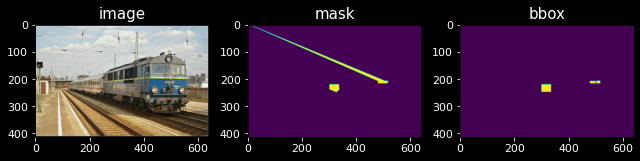

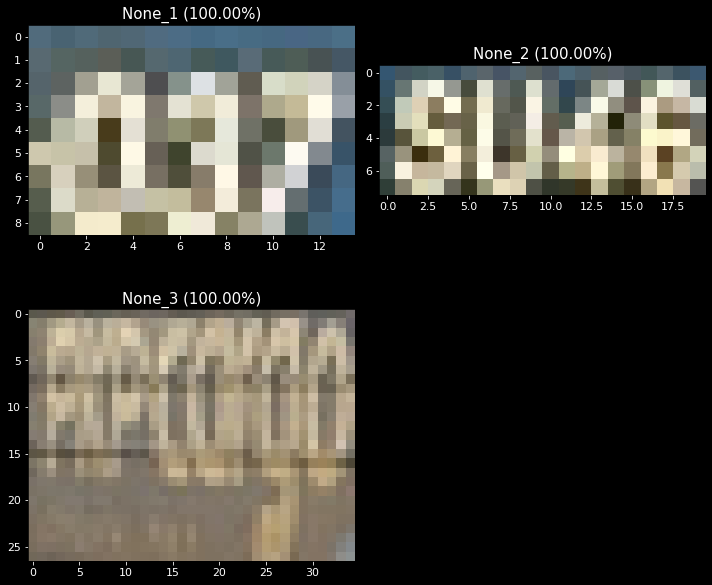

['FONTAINE', 'In']
[array([ 20, 110,  83, 113,  82, 122,  20, 118]), array([452, 130, 479, 129, 478, 158, 439, 159])]


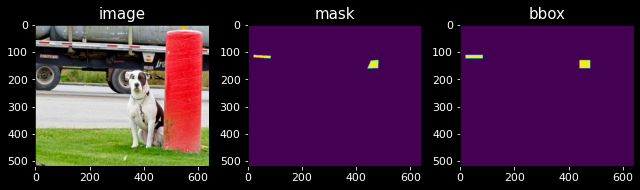

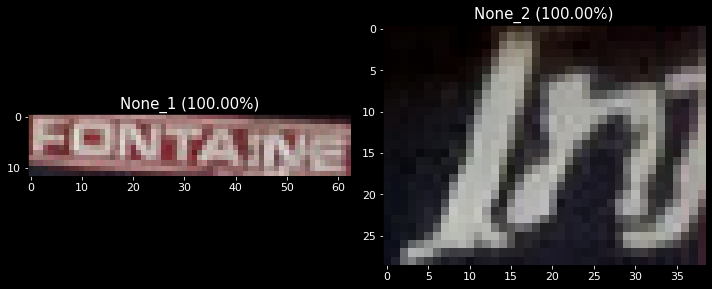

['GALLON', 'wy', '1200', '1100']
[array([191, 135, 191, 135, 200, 156, 284, 105, 274,  83, 189, 131]), array([286,  77, 294,  86, 306,  79, 304,  67,  -1,  -1,  -1,  -1]), array([286,  93, 291, 102, 311,  89, 307,  82,  -1,  -1,  -1,  -1]), array([302, 140, 302, 140, 304, 149, 323, 144, 321, 135,  -1,  -1])]


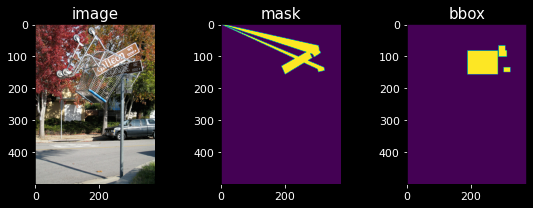

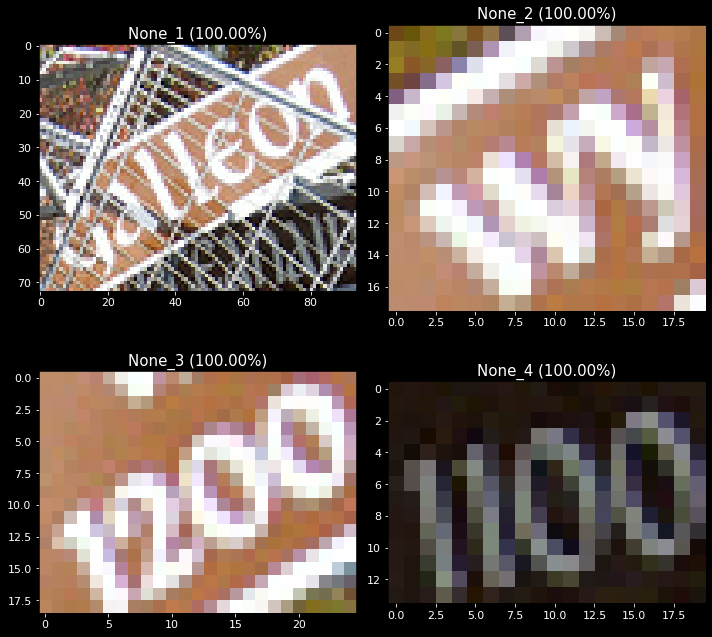

['BARBARA', 'KINGSOLVER', 'The', 'Poisonwood', 'Bible', 'York', 'Times', 'Bestseller', 'TO', 'GUIDE', 'COMPLETE', 'SQUARE', 'BE', 'Tn', 'DARF', 'Stitches', 'Embroidery']
[array([178, 132, 173, 197, 187, 197, 188, 132,  -1,  -1,  -1,  -1,  -1,
        -1]), array([204, 124, 200, 197, 197, 197, 196, 207, 213, 207, 215, 123,  -1,
        -1]), array([272, 170, 273, 184, 287, 185, 286, 158, 279, 156, 279, 167,  -1,
        -1]), array([298, 129, 296, 213, 309, 215, 311, 129,  -1,  -1,  -1,  -1,  -1,
        -1]), array([317, 190, 319, 154, 330, 154, 329, 188,  -1,  -1,  -1,  -1,  -1,
        -1]), array([462, 181, 472, 184, 472, 159, 463, 159,  -1,  -1,  -1,  -1,  -1,
        -1]), array([474, 168, 474, 168, 475, 200, 475, 200, 486, 200, 486, 172,  -1,
        -1]), array([486, 158, 491, 213, 491, 213, 501, 213, 498, 160,  -1,  -1,  -1,
        -1]), array([175, 293, 173, 317, 187, 317, 187, 293,  -1,  -1,  -1,  -1,  -1,
        -1]), array([157, 278, 155, 333, 169, 331, 171, 278, 171, 278

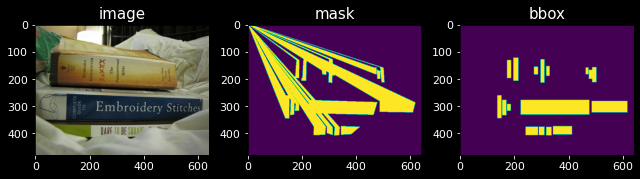

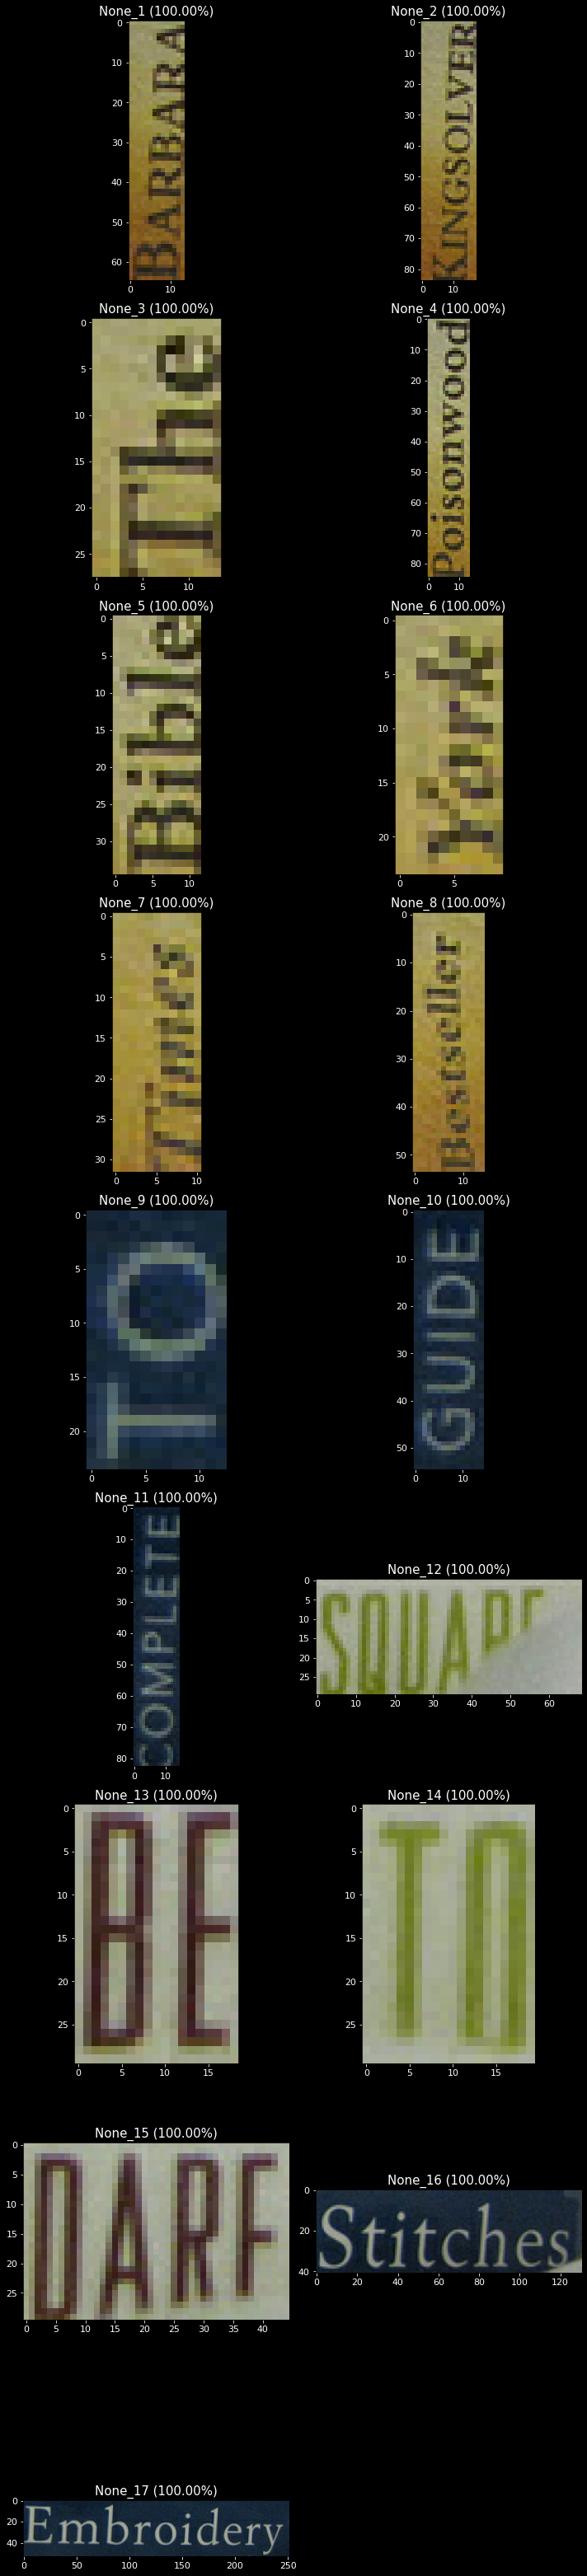

['10', 'N&#186;', '10']
[array([171, 156, 171, 168, 187, 169, 187, 156]), array([134, 277, 147, 277, 146, 290, 133, 289]), array([148, 277, 149, 289, 160, 289, 161, 278])]


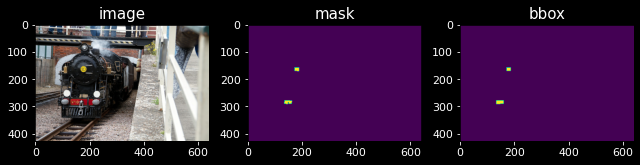

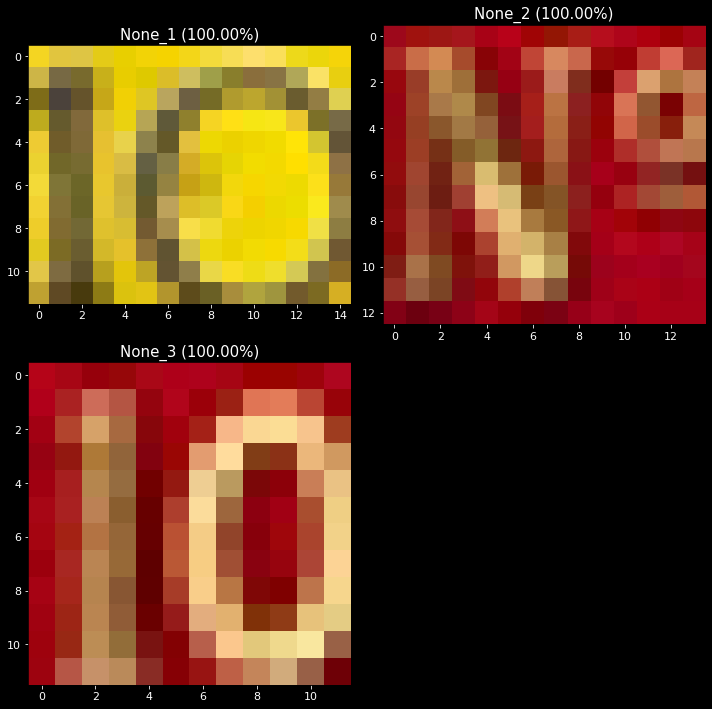

In [7]:
from utils.image import *

for _, row in dataset.sample(5, random_state = 0).iterrows():
    masks = [np.array(m) for m in row['mask']]
    boxes = [np.maximum(0, np.array(b)) for b in row['box']]
    texts = row['label']

    print(texts)
    print(masks)
    img = load_image(row['filename'])
    plot_multiple(
        image = img, 
        mask = mask_utils.create_poly_mask(img, masks),
        bbox = box_utils.box_as_mask(img, boxes),
        plot_type = 'imshow', ncols = 3, size = 3
    )
    box_utils.show_boxes(img, boxes, labels = texts)